# Collaborating Countries Publication Density Mapping
### Keith E. Maull<sup>1</sup>, Michaeleen Trimarchi<sup>2</sup> Terry Murray<sup>3</sup>

##### September 21, 2016 <br/>* Last Upated September 27, 2016

#### NCAR Library, National Center for Atmospheric Research
1. kmaull@ucar.edu 
2. trimarchi@ucar.edu
3. tmurray@ucar.edu

## Problem Statement
Some of the traditional data sources for publication / collaboration information only produce raw form output of the collaborating contries given search parameters.  Such sources do not necessarily produce maps visual maps of the data, so we would like to display author collaboration counts _by country_ onto a map.  

## Solution Proposals
Python includes several good libraries for building maps and placing data on them. There are two possibilities.

*  Interactive Maps with Folium
* Static maps with Matplotlib [Basemap]()

In [1]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from mpl_toolkits.basemap import Basemap

There are 3 files we will need (in the repository path-relative to this notebook).

| File | Purpose |
|------|---------|
|[data/COUNTRY_Collaborations.csv](data/COUNTRY_Collaborations.csv) | This file contains the country names (normalized) and collaboration counts. |
|[data/country_info.tsv](data/country_info.tsv) | This file contains the country data to crosswalk country names to ISO3. |
|[data/country_centroids_primary.csv](data/country_centroids_primary.csv) | This file contains the centroid data for country codes -- and was originally extracted [here](). |


In [2]:
# load collaboration data
df_collab = pd.read_csv("data/COUNTRY_Collaborations.csv")
df_collab.set_index('country', inplace=True)

# load country data for fips<->ISO3 lookup
df_countries = pd.read_csv("data/country_info.tsv", delimiter='\t')

#load centroid data (all data in fips10)
df_centroids = pd.read_csv("data/country_centroids_primary.csv", delimiter='\t')

We will set up the data we really need now:

In [3]:
df_countries['Country'] = [i.lower() for i in df_countries['Country']]
df_countries['ISO3'] = df_countries['ISO3'].tolist()
df_countries['fips'] = df_countries['fips'].tolist()
df_countries['collab_counts'] = 0
df_countries['bin'] = -1

The major trick we must employ is mapping the country to its centroid via the FIPS code -- the files we have here must all be combined to make sure the data contains exactly what we want.

In [4]:
df_collab_countries = [c_collab.lower() for c_collab in df_collab.index]
df_all_countries = df_countries['Country'].tolist()

for c in df_collab_countries:
    if c in df_all_countries:     
        df_countries.loc[df_countries['Country']==c,'collab_counts'] \
            = df_collab.loc[c.upper(), 'counts']
        
        
        fips = df_countries[df_countries['Country']==c]['fips'].iloc[0]
        
        lat_lon = df_centroids[df_centroids['FIPS10']==fips][['LAT','LONG']]                                   

        df_countries.loc[df_countries['Country']==c, 'lat'] = lat_lon['LAT'].iloc[0]
        df_countries.loc[df_countries['Country']==c, 'lon'] = lat_lon['LONG'].iloc[0]     

# Now that we have the countries, counts and centroids ... we can get some maps drawn!

## SOLUTION 1 : FOLIUM

**NOTE:** The country data has an error, where `SDS` is South Sudan in the `world-countries.json` file and was `SSD` in the `country_info.tsv`. The `country_info.tsv` was updated to `SDS`. 

The Folium solution is very straightforward and no tricks are really required to make it work the way we expect.

In [5]:
import folium
world_geo = r'data/world-countries.json'
df_collab = df_countries[:][['ISO3', 'lat', 'lon', 'fips', 'Country', 'collab_counts']]

map = folium.Map(location=[48, -48], zoom_start=2)
map.choropleth(
    geo_path=world_geo,
    data=df_collab,
    columns=['ISO3','collab_counts'],
    threshold_scale=[1, 8, 15, 20, 30, 40],
    key_on='feature.id',
    fill_color='BuPu',
    fill_opacity=0.3,
    line_weight=2
    )

for d in df_countries.loc[df_countries['collab_counts']>0][['ISO3','lat', 'lon', 'Country', 'collab_counts']].itertuples(): 
    folium.Marker([d.lat, d.lon], popup="{}\n\n{}".format(d.Country.title(), d.collab_counts)).add_to(map)
    
map

This is awesome (author's bias) ... and interactive (click on the marker).

## SOLUTION 2: BASEMAP

While the interactive solution is awesome, what we really also would like is a static map.  To get this job done, we'll need [Basemap]() see some cool stuff.  We gain some inspiration from [here](http://ramiro.org/notebook/basemap-choropleth/), [here](http://introtopython.org/visualization_earthquakes.html) and [here](https://github.com/onenorth/interactive-svg-map/tree/master/src/data). **NOTE:** The [shapefiles](./data/shapefiles) are required to draw the maps.

In [6]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection

In [7]:
### set up the map color bins
num_colors = 9
values = df_countries.loc[df_countries['collab_counts']>0,'collab_counts']
cm = plt.get_cmap('Greens')
scheme = [cm(i / num_colors) for i in range(num_colors)]
bins = np.linspace(values.min(), values.max(), num_colors)
df_countries.loc[df_countries['collab_counts']>0, 'bin'] = np.digitize(values, bins) - 1

Because space is limited, we need to place country labels elsewhere in the map.  We're going to manually group country labels where they are most optimal.  We do this by grouping the countries which need to be labeled together in [`europe_north.txt`](./data/europe_north.txt) and [`europe_west.txt`](./data/europe_west.txt) files.

In [8]:
with open("data/europe_north.txt") as fi:
    eu_north = fi.readlines()
    eu_north = [c.strip().lower() for c in eu_north]
    
with open("data/europe_west.txt") as fi:
    eu_west = fi.readlines()
    eu_west = [c.strip().lower() for c in eu_west]

Now we define the core plotting function ...

In [73]:
def generate_and_save_plot(plot_fname, with_country_labels=True):
    # CORE PLOTTING: http://ramiro.org/notebook/basemap-choropleth/
    # LABELS: http://introtopython.org/visualization_earthquakes.html
    # MINIMAL MAP: https://github.com/onenorth/interactive-svg-map/tree/master/src/data

    shapefile = "data/shapefiles/ne_110m_admin_0_countries_lakes"
    fig = plt.figure(figsize=(22, 12))

    ax = fig.add_subplot(111, axisbg='w', frame_on=False)

    m = Basemap(lon_0=0, projection='robin')
    m.drawmapboundary(color='w')
    m.readshapefile(shapefile, 'units', color='#fcfcfc', linewidth=.1)

    for info, shape in zip(m.units_info, m.units):    
        iso3 = info['adm0_a3']

        try:
            bin = df_countries.loc[df_countries['ISO3']==iso3,'bin'].iloc[0]
            edgecolor = '#afafaf'
        except IndexError:
            bin = -1
            edgecolor = '#ffffff'

        if bin < 0 :
            color = '#fcfcfc'
        else:
            color = scheme[bin]

        patches = [Polygon(np.array(shape), True)]
        pc = PatchCollection(patches)
        pc.set_facecolor(color)
        pc.set_edgecolor(edgecolor)
        ax.add_collection(pc)

    # these coordinates are used to place the data for european collaborators
    eun_lat, eun_lon = -12.125004, 80.372757  # somewhere in the norwegian sea
    euw_lat, euw_lon = -36.001956, 57.468125  # somewhere in the north atlantic

    for d in df_countries.loc[df_countries['collab_counts']>0][['ISO3','lat', 'lon', 'Country', 'collab_counts']] \
                .sort_values(by='collab_counts', ascending=False).itertuples(): 
        # require to project onto map with annotate
        lon, lat = m(d.lon, d.lat)

        eun_lat_lon_m = m(eun_lat, eun_lon)
        euw_lat_lon_m = m(euw_lat, euw_lon)

        title = d.Country.title()
        
        # set up label formats
        if with_country_labels:
            title_format_sm , title_format_lg = "{} {}", "{}\n{}"
        else:
            title_format_sm , title_format_lg = "", ""
            
        # set up marker and fontsize
        fontsize="medium"
        if d.collab_counts < 6:
            markersize=4
            fontsize="small"
        elif d.collab_counts > 5 and d.collab_counts < 11:
            markersize=8
        elif d.collab_counts >10 and d.collab_counts < 21:
            markersize=12
        else:
            markersize=16
        
        # plot the markers
        m.plot(lon, lat, 'o', markersize=markersize, latlon=False)

        # place text based on special placement issues
        if d is False or title.lower() in eu_north:
            plt.annotate(title_format_sm.format(title, int(d.collab_counts)), \
                         xy=(lon, lat), xytext=eun_lat_lon_m, 
                         size='small', multialignment='center'),
    #                      arrowprops=dict(arrowstyle="->",
    #                                      connectionstyle="arc3"))
            eun_lon -= 3
            eun_lat += 0.4
        elif d is False or title.lower() in eu_west:
            plt.annotate(title_format_sm.format(title, int(d.collab_counts)), \
                         xy=(lon, lat), xytext=euw_lat_lon_m, 
                         size='small', multialignment='center'),
    #                      arrowprops=dict(arrowstyle="->",
    #                                      connectionstyle="arc3"))
            euw_lon -= 2.8
            euw_lat += 0.60
        elif title.lower() == 'japan': # japan and s. korean are overlapping, so we move it out into the pacific a bit
            plt.annotate(title_format_lg.format(title, int(d.collab_counts)), \
                         xy=(lon, lat), xytext=m(139, 30), \
                         size=fontsize, multialignment='center')        
        elif title.lower() == 'south korea': # japan and s. korean are overlapping, so we move it out into the pacific a bit
            plt.annotate(title_format_lg.format(title.replace(' ','\n'), int(d.collab_counts)), \
                         xy=(lon, lat), xytext=m(128.13, 36.51), \
                         size=fontsize, multialignment='center')                    
        elif title.lower() == 'chile': # japan and s. korean are overlapping, so we move it out into the pacific a bit
            plt.annotate(title_format_lg.format(title, int(d.collab_counts)), \
                         xy=(lon, lat), xytext=m(-80, -30), \
                         size=fontsize, multialignment='center')                    
        else:
            plt.annotate(title_format_lg.format(title, int(d.collab_counts)), \
                         xy=(lon, lat), xytext=(lon, lat), \
                         size=fontsize, multialignment='center')

    plt.savefig(plot_fname, dpi=300, bbox_inches='tight', pad_inches=.2)
    plt.show()

Do some plotting ...

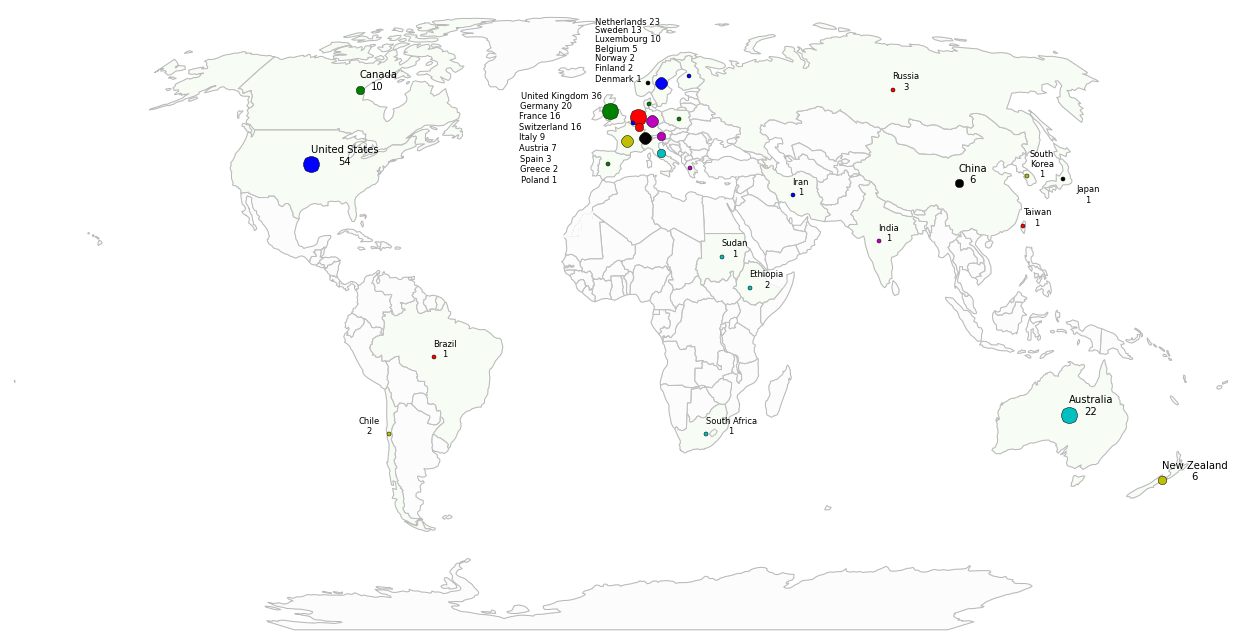

In [74]:
generate_and_save_plot("collaboration_world_vis_B1.png", with_country_labels=True)

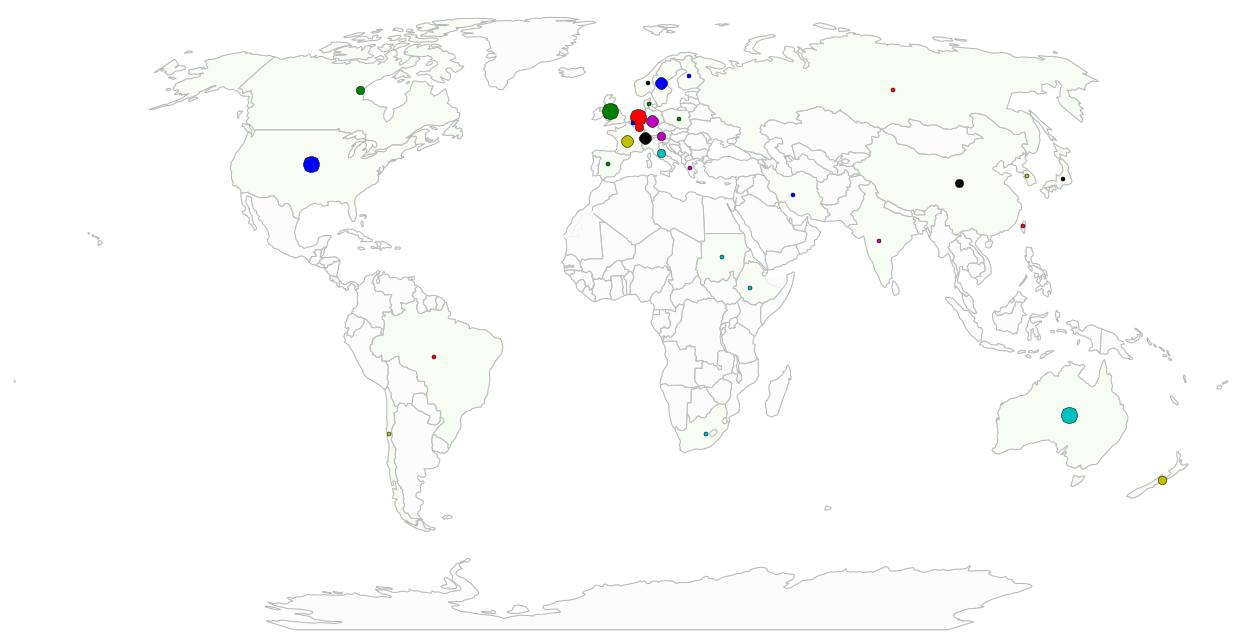

In [72]:
generate_and_save_plot("collaboration_world_vis_A1.png", with_country_labels=False)

#### YIPPEEE! And we're done ...